# IMPORTING LIBRARIES

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import math

# IMPORTING THE DATA INTO NUMPY ARRAYS

In [120]:
clean_arr = np.loadtxt("wifi_db/clean_dataset.txt")
noisy_arr = np.loadtxt("wifi_db/noisy_dataset.txt")

# DEFINING FIXED VALUES AND LABELS

In [121]:
LABEL_COL = clean_arr.shape[1] - 1 
DATASET_SIZE = clean_arr.shape[0]
NUM_FOLDS = 10
labels = [1, 2, 3, 4]

# DEFINING THE NODE CLASS

In [122]:
class Node():

    # if node is leaf, value is used to store label
    # if node is parent, value is used to store the split_value AND
    # attr is used to store the attribute that is split on
    def __init__(self, **kwargs):
        self.label = kwargs.get('label', -1)
        self.value = kwargs.get('value', 0)
        self.attr = kwargs.get('attr', 0)
        self.left = kwargs.get('left', None)
        self.right = kwargs.get('right', None)
    
    def set_left(self, left):
        self.left = left
    
    def set_right(self, right):
        self.right = right
    
    def is_leaf(self):
        return self.left == None and self.right == None
    
    def is_parent_of_leafs(self):
        return self.left.is_leaf() and self.right.is_leaf()

    def to_string(self):
        if self.is_leaf():
            return str(int(self.label))
        else:
            return 'x_' + str(self.attr) + ' > ' + str(self.value)

# FUNCTIONS FOR TREE CALCULATIONS

In [123]:
def count_leafs(root):
    if root is None :
        return 0
    elif root.is_leaf():
        return 1
    else:
        return count_leafs(root.left) + count_leafs(root.right)

def calc_depth(root):
    if (root is None):
        return 0

    return max(calc_depth(root.left), calc_depth(root.right)) + 1

# FUNCTIONS FOR CALCULATIONS

In [124]:
def entropy(dataset):
    dataset_size,_ = dataset.shape
    res = np.zeros(len(labels))
    for i in range(len(labels)):
        res[i] = calc_label_instances(dataset, labels[i])
    res = res / dataset_size
    log_res = np.where(res > 0, np.log2(res), res)
    res = res * log_res
    return - np.sum(res)

def remainder(dataset, split_index):
    dataset_size,_ = dataset.shape
    left_info_gain = (split_index + 1) / dataset_size * entropy(dataset[: (split_index + 1)])
    right_info_gain = (dataset_size - split_index)/dataset_size * entropy(dataset[(split_index + 1):])
    return left_info_gain + right_info_gain

def calc_info_gain(start_entropy, dataset, split_index):
    return start_entropy - remainder(dataset, split_index)

def get_mid(a, b):
    return (a + b) / 2

def calc_label_instances(dataset, label):
    return np.count_nonzero(dataset[:, LABEL_COL] == label)

def find_majority_label(dataset):
    transformed = list(map(lambda x: calc_label_instances(dataset, x), labels))
    return transformed.index(max(transformed)) + 1

# FUNCTIONS FOR VISUALISING THE TREE

In [125]:
node_box = dict(boxstyle="round",fc="1.0")
leaf_box = dict(boxstyle="square", fc="lightblue")
arrow = dict(arrowstyle="<-")
width_factor = 0.3
depth_factor = 2.5

def create_plot(root, depth):
    fig = plt.figure(1,facecolor='white')
    fig.clf()
    axprops=dict(xticks=[],yticks=[])
    create_plot.ax1=plt.subplot(111,frameon=False,**axprops)
    plot_tree.totalW=float(count_leafs(root)) * width_factor
    plot_tree.totalD=float(depth)
    plot_tree.xOff = plot_tree.totalW / 2.0
    plot_tree.yOff=1.0
    plot_tree(root,(0.5,1.0),(0.5,1.0),depth,depth)
    plt.show()

def plot_node(text, ctr, parent, node_type):
    create_plot.ax1.annotate(text,xy=parent,xycoords='axes fraction',xytext=ctr,textcoords='axes fraction',va='center',ha='center',bbox=node_type ,arrowprops=arrow)

def plot_branch_text(ctr, parent, text):
    if text is None: return
    x=(parent[0]+ctr[0])/2.0
    y=(parent[1]+ctr[1])/2.0
    create_plot.ax1.text(x, y, text)

def plot_tree(root, ctr, parent, depth, initial_depth):
    if root is None: return

    if ctr == parent:
        plot_node(root.to_string(), ctr, parent, node_box)

    plot_tree.yOff = 1.0 - (initial_depth - depth + 1)/plot_tree.totalD * depth_factor
    total_count = count_leafs(root)
    left = (0,0)
    right = (0,0)

    if not root.left is None:
        left_count = count_leafs(root.left)
        diff = total_count / 2 - left_count
        left = (ctr[0] - ((diff + left_count / 2.0) / plot_tree.totalW), plot_tree.yOff)
        # plot_branch_text(left, ctr, False)
        plot_node(root.left.to_string(), left, ctr, leaf_box if root.left.is_leaf() else node_box)

    if not root.right is None:
        right_count = count_leafs(root.right)
        diff = total_count / 2 - right_count
        right = (ctr[0] + ((diff + right_count / 2.0) / plot_tree.totalW), plot_tree.yOff)
        # plot_branch_text(right, ctr, True)
        plot_node(root.right.to_string(), right, ctr, leaf_box if root.right.is_leaf() else node_box)

    plot_tree(root.left, left, ctr, depth - 1, initial_depth)
    plot_tree(root.right, right, ctr, depth - 1, initial_depth)


# FUNCTIONS FOR EVALUATION

In [126]:
def traverse_tree(root, datapoint):
    if(root.left is None and root.right is None):
        return root.label
    attr = root.attr
    split_val = root.value
    if(datapoint[attr] <= split_val):
        return traverse_tree(root.left, datapoint)
    else:
        return traverse_tree(root.right, datapoint)
    

def evaluate(test_db, trained_tree):

    confusion_matrix = np.zeros(16).reshape((4, 4))
    for i in range(len(test_db)):
        classified_label = traverse_tree(trained_tree, test_db[i])
        actual_label = test_db[i][LABEL_COL]
        confusion_matrix[int(actual_label) - 1,int(classified_label) - 1] += 1
    
    true_positive = confusion_matrix[0,0] 
    true_negative = confusion_matrix[1,1] + confusion_matrix[2,2] + confusion_matrix[3,3]
    all_values = len(test_db)
    accurately_classified_data = true_positive + true_negative
    accuracy = accurately_classified_data / all_values
    
    return (confusion_matrix, accuracy)

def calculate_recall(matrix, i):
    row = matrix[i]
    return matrix[i][i] / sum(row)

def calculate_precision(matrix, i):
    col = matrix[:, i]
    return matrix[i][i] / sum(col)


# FIND SPLIT

In [127]:
def find_split(trng_data):

    split_attribute = -1
    split_value = 0
    split_index = 0
    overall_highest_info_gain = 0

    # start_entropy calculated on the entire dataset
    start_entropy = entropy(trng_data)
    dataset_size, _ = trng_data.shape
    final_sorted_dataset = trng_data
    
    # loops through each attribute, finding its optimal split for each
    for i in range(LABEL_COL):
        sorted_dataset = trng_data[trng_data[:, i].argsort()]
        current_split_value = 0
        feature_highest_info_gain = 0
        current_split_index = 0

        # calculates info gain for each index split
        for j in range(dataset_size - 1):

            if sorted_dataset[j][LABEL_COL] == sorted_dataset[j + 1][LABEL_COL]: continue

            mid = get_mid(sorted_dataset[j][i], sorted_dataset[j + 1][i])
            info_gain = calc_info_gain(start_entropy, sorted_dataset, j)

            # takes split index for the highest info gain within a feature (in one column)
            if (not math.isnan(info_gain)) and info_gain > feature_highest_info_gain:
                current_split_value = mid
                feature_highest_info_gain = info_gain
                current_split_index = j

        # takes split index for highest info gain between all features
        if overall_highest_info_gain < feature_highest_info_gain:
            overall_highest_info_gain = feature_highest_info_gain
            split_attribute = i
            split_value = current_split_value
            split_index = current_split_index
            final_sorted_dataset = sorted_dataset
        
    return (split_attribute, split_value, split_index, final_sorted_dataset)


# BUILDING THE DECISION TREE MODEL

In [128]:
def decision_tree_learning(training_dataset, depth):
    first_label = training_dataset[0][LABEL_COL]
    if np.all(training_dataset[:, LABEL_COL] == first_label):
        return (Node(label=first_label), depth)
    else:
        split_attr, split_value, split_index, sorted_dataset = find_split(training_dataset)
        curr_node = Node(value=split_value, attr=split_attr)
        left_branch, left_depth = decision_tree_learning(sorted_dataset[:split_index + 1], depth + 1)
        right_branch, right_depth = decision_tree_learning(sorted_dataset[split_index + 1:], depth + 1)
        curr_node.set_left(left_branch)
        curr_node.set_right(right_branch)
        curr_node.label = find_majority_label(training_dataset)
    return (curr_node, max(left_depth, right_depth))

# CROSS VALIDATION 

In [129]:

def cross_validation(data):

    recall_per_class = np.zeros(4)
    precision_per_class = np.zeros(4)
    f1_per_class = np.zeros(4)
    sum_accuracy_pruned = 0
    sum_accuracy_unpruned = 0
    sum_confusion_matrix = np.zeros(16).reshape((4, 4))
    np.random.shuffle(data)

    for i in range(NUM_FOLDS):

        # allocating indexes where data will be sliced
        size_per_fold = int(len(data) / NUM_FOLDS)
        begin = i * size_per_fold
        mid = (i + 1) * size_per_fold
        end = (i + 2) * size_per_fold

        # creating test, training and validation datasets
        if (i == NUM_FOLDS - 1):
            val_data = data[0:size_per_fold]
            test_data = data[begin:mid]
            trng_data = data[size_per_fold:begin]
        else:
            test_data = data[begin: mid]
            val_data = data[mid: end]
            trng_data = np.delete(data, slice(begin, end), axis=0)

        # building pre-pruned decision tree model
        root, depth = decision_tree_learning(trng_data, 0)

        # saving accuracy of unpruned model
        _, unpruned_accuracy = evaluate(test_data, root)
        sum_accuracy_unpruned += unpruned_accuracy

        # pruning tree
        prune(root, root, val_data)

        # saving accuracy of pruned model and printing pruned decision tree
        confusion_matrix, pruned_accuracy = evaluate(test_data, root)
        sum_accuracy_pruned += pruned_accuracy
        sum_confusion_matrix += confusion_matrix
        new_depth = calc_depth(root)
        print("Printing decision tree for iteration", i)
        create_plot(root,new_depth)
        
        for i in range(len(labels)):
            recall_per_class[i] += calculate_recall(confusion_matrix, i)
            precision_per_class[i] += calculate_precision(confusion_matrix, i)
        
    avg_unpruned_accuracy = sum_accuracy_unpruned / NUM_FOLDS
    print("Average accuracy without pruning: ", avg_unpruned_accuracy)
    avg_accuracy = sum_accuracy_pruned / NUM_FOLDS
    print("Average accuracy with pruning:", avg_accuracy)
    print("Gain in accuracy from pruning:", avg_accuracy - avg_unpruned_accuracy)
    print("All following values are after pruning.")
    average_recall_per_class = recall_per_class / NUM_FOLDS
    print("Average recall per class:", average_recall_per_class)
    average_precision_per_class = precision_per_class / NUM_FOLDS
    print("Average precision per class:", average_precision_per_class)
    f1_per_class = 2 * average_recall_per_class * average_precision_per_class / (average_recall_per_class + average_precision_per_class)
    print("F1 values per class:", f1_per_class)
    avg_confusion_matrix = sum_confusion_matrix / NUM_FOLDS
    print("Average confusion matrix per class:", avg_confusion_matrix)
    
    return (avg_accuracy, average_recall_per_class, average_precision_per_class, f1_per_class, avg_confusion_matrix)

# PRUNING

In [130]:
def prune(root, node, val_data):

    if (node.is_leaf()) :
        return

    prune(root, node.left, val_data)
    prune(root, node.right, val_data)

    _,prev_accuracy = evaluate(val_data, root)

    if node.is_parent_of_leafs():
        
        left = node.left
        right = node.right
        node.left = None
        node.right = None
    
        _,new_accuracy = evaluate(val_data, root)

        if prev_accuracy > new_accuracy:
            node.left = left
            node.right = right

Printing decision tree for iteration 0


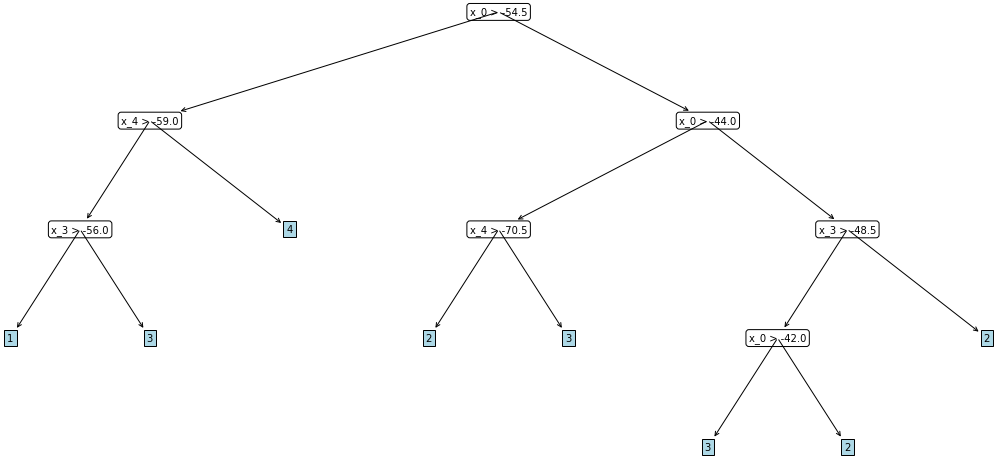

Printing decision tree for iteration 1


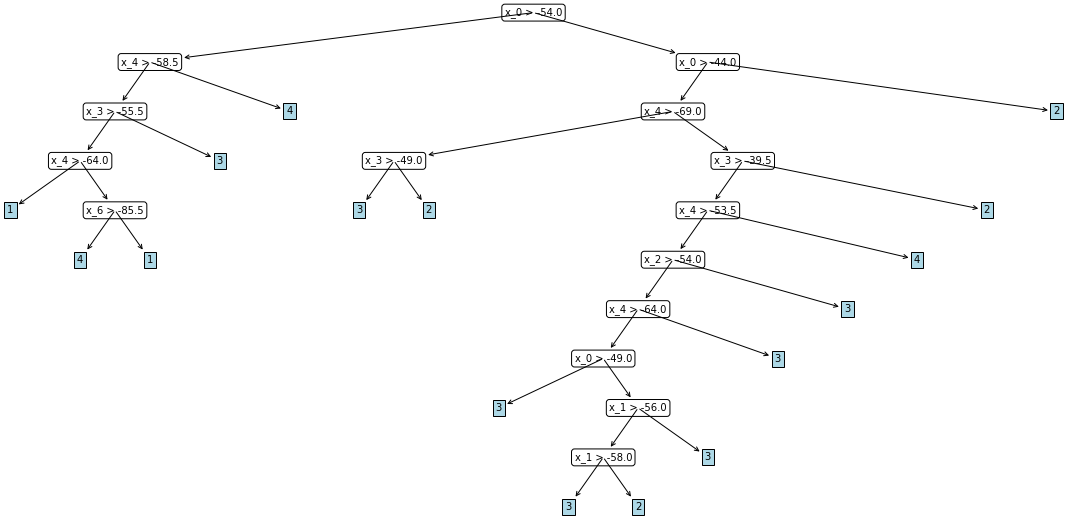

Printing decision tree for iteration 2


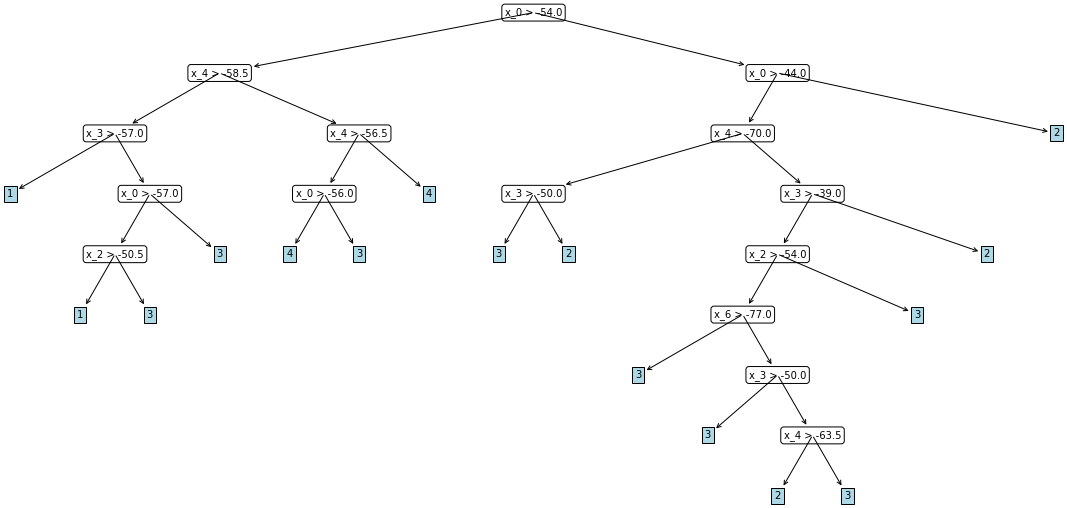

Printing decision tree for iteration 3


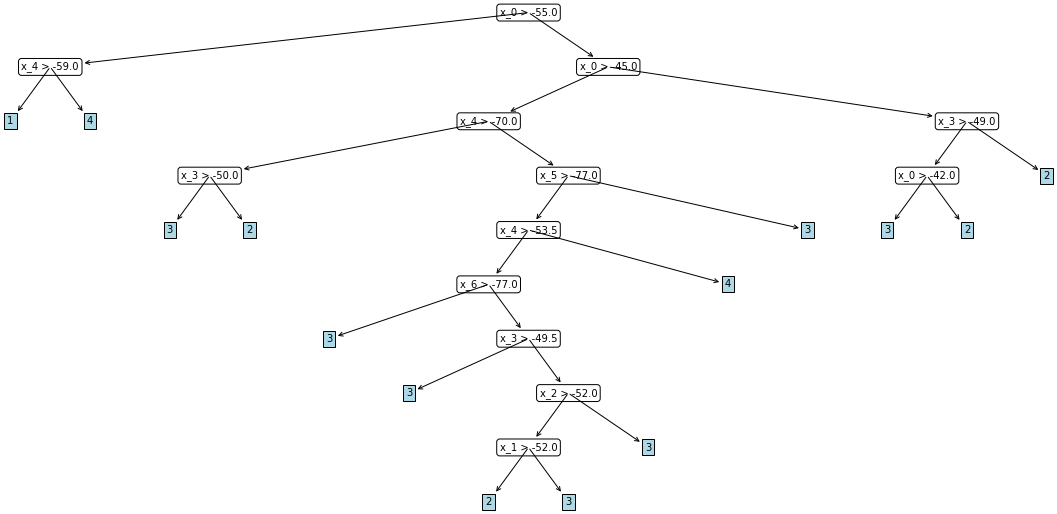

Printing decision tree for iteration 4


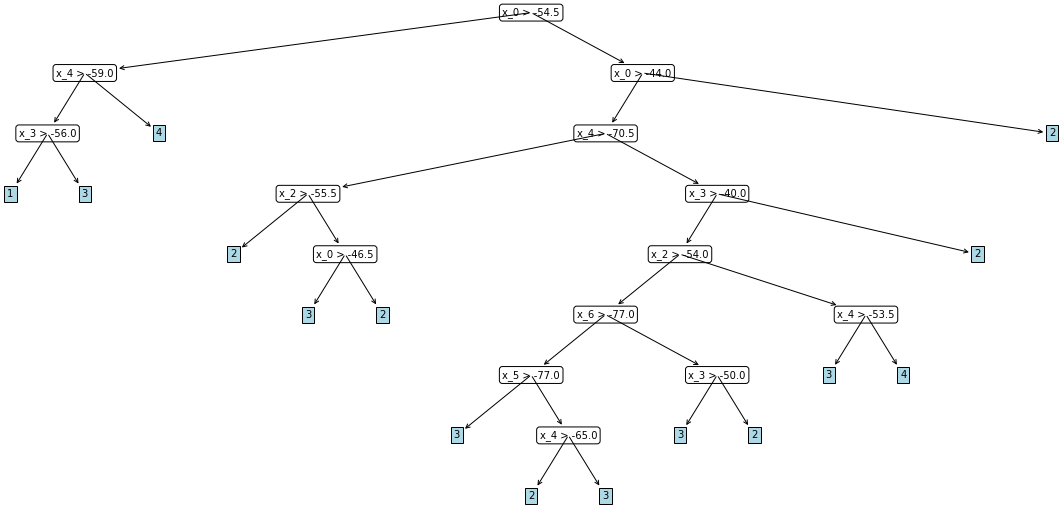

Printing decision tree for iteration 5


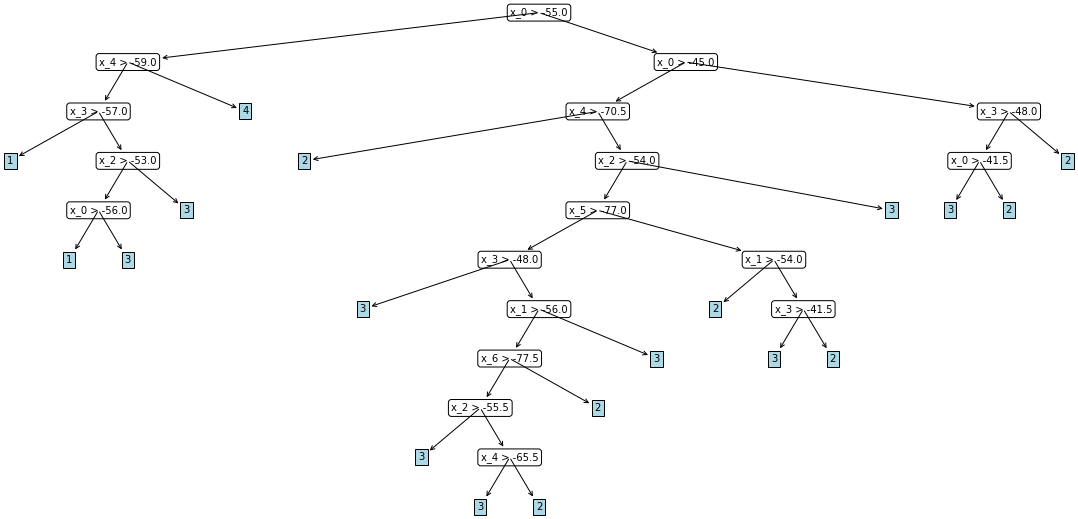

Printing decision tree for iteration 6


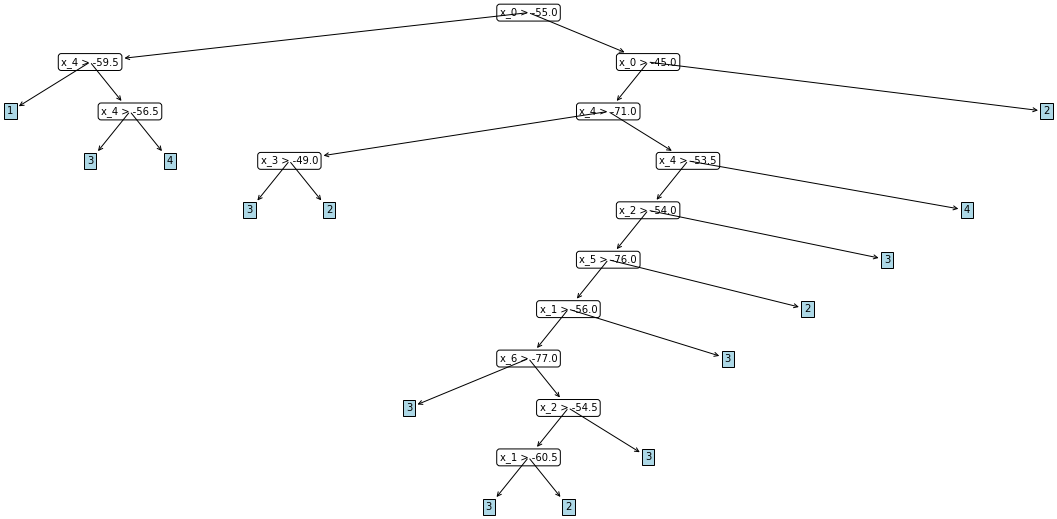

Printing decision tree for iteration 7


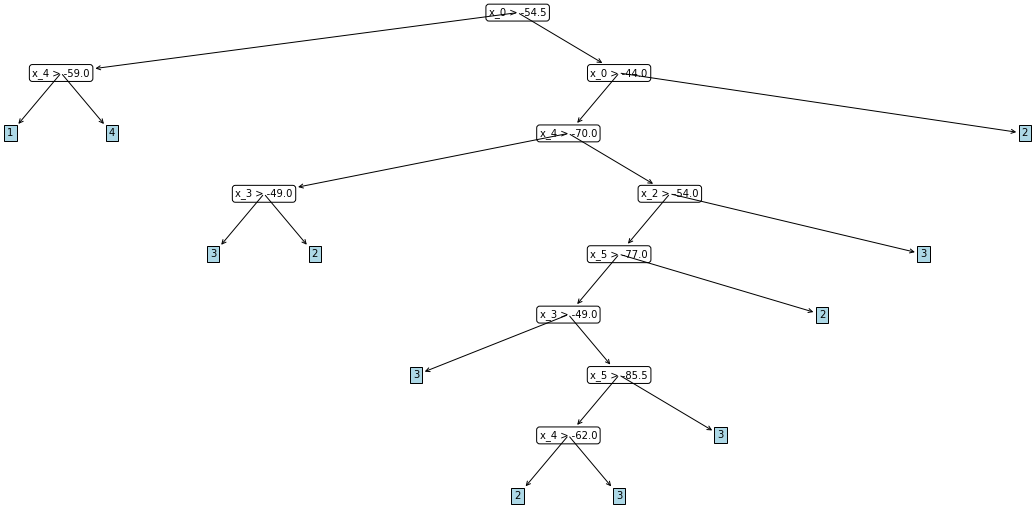

Printing decision tree for iteration 8


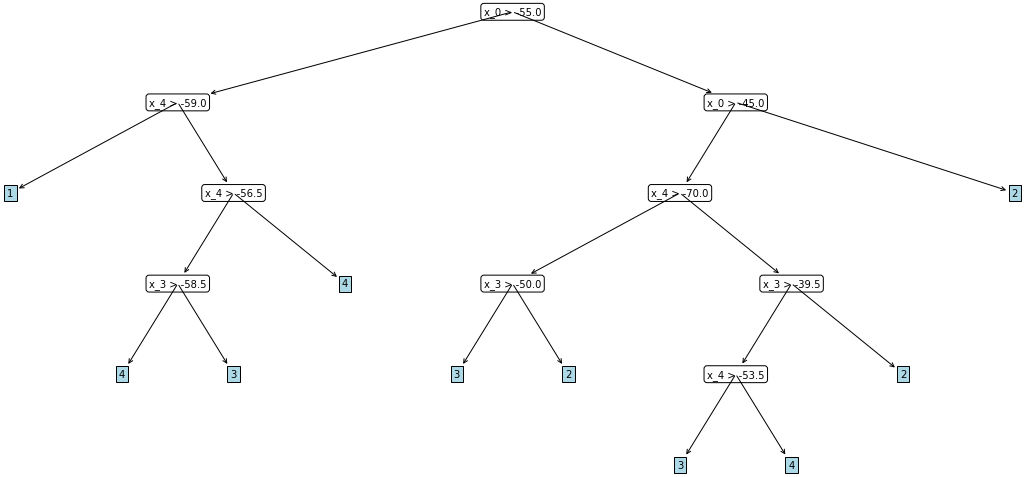

Printing decision tree for iteration 9


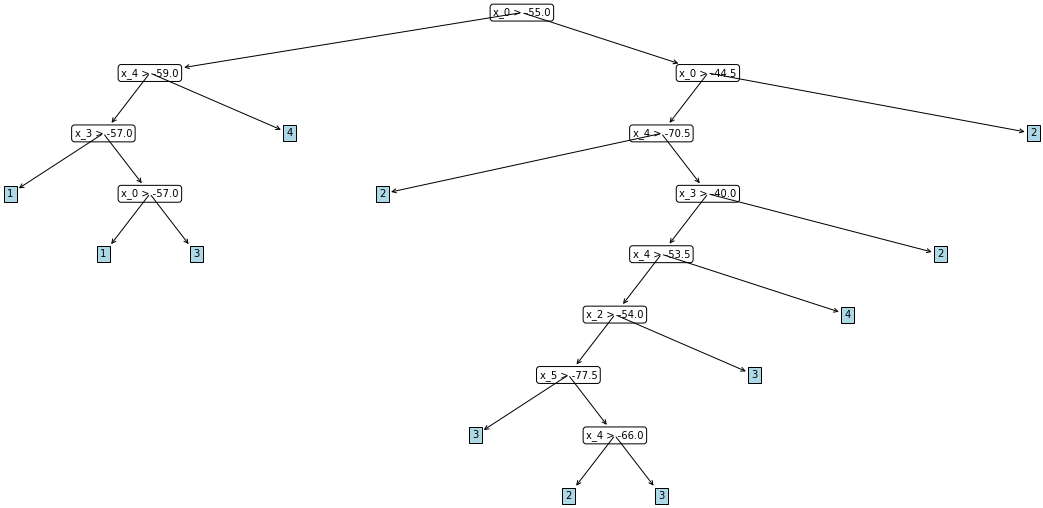

Average accuracy without pruning:  0.9745000000000001
Average accuracy with pruning: 0.97
Gain in accuracy from pruning: -0.0045000000000001705
All following values are after pruning.
Average recall per class: [0.99787234 0.95565236 0.94706808 0.98224668]
Average precision per class: [0.97718222 0.96039815 0.94156608 0.99827586]
F1 values per class: [0.98741891 0.95801938 0.94430907 0.9901964 ]
Average confusion matrix per class: [[49.9  0.   0.1  0. ]
 [ 0.  47.7  2.3  0. ]
 [ 0.7  1.9 47.3  0.1]
 [ 0.5  0.   0.4 49.1]]


In [131]:
acc, recall, precision, f1, conf_matrix = cross_validation(clean_arr)